## Simulating and discretizing and AR1

Consider the AR1: $x_t = \rho x_{t-1} + \epsilon_t$, where $\rho=0.9$ and $\epsilon_t \sim N(0,\sigma^2)$ with $\sigma=0.01$.


__Simulate many random draws of $(x_t)$ to compute its ergodic variance. Compare with the theoretical formula__

In [14]:
ρ = 0.9
σ = 0.01

0.01

In [15]:
function τ(x::Float64)
    return ρ*x + randn()*σ
end

τ (generic function with 1 method)

In [22]:
using Random

In [24]:
rng = MersenneTwister(1234)
randn(rng, 10)

10-element Array{Float64,1}:
  0.8673472019512456
 -0.9017438158568171
 -0.4944787535042339
 -0.9029142938652416
  0.8644013132535154
  2.2118774995743475
  0.5328132821695382
 -0.27173539603462066
  0.5023344963886675
 -0.5169836206932686

In [26]:
rng = MersenneTwister(1235)
randn(rng, 10)

10-element Array{Float64,1}:
 -0.10918411943401604
  0.18272052861843807
 -1.7904615274198337
  0.5280217004231998
 -2.167134170146234
  0.7763594392654657
 -0.1017153686918011
  0.17983248782211442
  0.5327567873276706
 -0.1912674205629273

In [19]:
x0 = [1.0, 2.0, 3.0]

3-element Array{Float64,1}:
 1.0
 2.0
 3.0

In [20]:
[τ(i) for i in x0]

3-element Array{Float64,1}:
 0.8991750101596119
 1.7860136789122718
 2.702840763704634

In [21]:
τ.(x0)

3-element Array{Float64,1}:
 0.8921013859035718
 1.790883431664203
 2.7157846294576187

In [16]:
N = 100
T = 1000
sim = zeros(T+1, N)
for i in 1:T
    x0 = sim[i,:] ::AbstractVector{Float64}
    x1 = τ.(x0)
    sim[i+1,:] = x1
end

In [27]:
import PyPlot

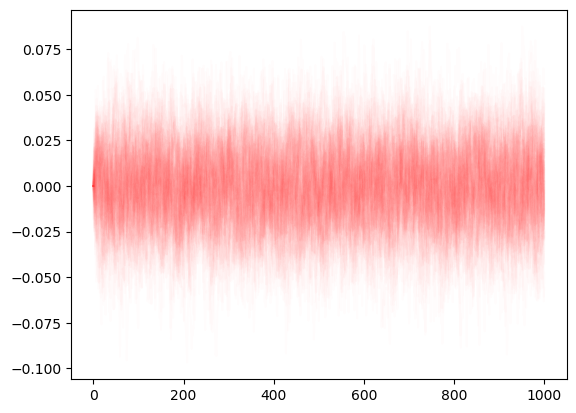

In [29]:
for n=1:N
    PyPlot.plot(sim[:,n], color="red", alpha=0.01)
end

In [31]:
using Statistics

In [32]:
std(sim[end,:])

0.021280697713862214

In [34]:
1/sqrt(1-ρ^2)*σ

0.022941573387056182

__Write a routine to discretize $(x_t)$ using Tauchen method. Compare with QuantEcon__

In [36]:
using QuantEcon


In [56]:
mc = tauchen(3, 0.5, σ)

Discrete Markov Chain
stochastic matrix of type Array{Float64,2}:
[0.5 0.4997339972474304 0.00026600275256960515; 0.041632258331775224 0.9167354833364496 0.041632258331775196; 0.00026600275256962515 0.4997339972474304 0.5]

In [57]:
mc.p

3×3 Array{Float64,2}:
 0.5          0.499734  0.000266003
 0.0416323    0.916735  0.0416323
 0.000266003  0.499734  0.5

In [58]:
mc.p
[mc.state_values...]

3-element Array{Float64,1}:
 -0.034641016151377546
  0.0
  0.034641016151377546

In [59]:
sim = simulate(mc, 1000)

1000-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.034641016151377546
 -0.034641016151377546
 -0.034641016151377546
  0.0
  0.0
  0.0

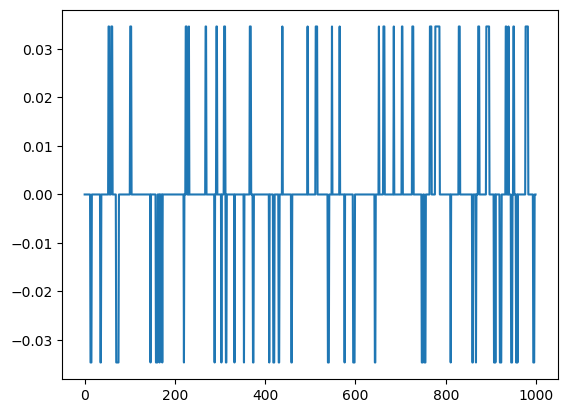

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6571558550>

In [60]:
PyPlot.plot(sim)

__Write a routine to discretize $(x_t)$ using Rouwenhorst method. Compare with QuantEcon__

## Basic Asset Pricing model

A financial asset yields dividend $(x_t)$, which follows an AR1. It is evaluated using the stochastic discount factor: $\rho_{0,t} = \beta^t \exp(y_t)$  where $\beta<1$ and $y_t$ is an $AR1$.
The price of the asset is given by $p_0 = \sum_{t\geq 0} \rho_{0,t} U(x_t)$ where $U(u)=\exp(u)^{0.5}/{0.5}$.
Our goal is to find the pricing function $p(x,y)$, which yields the price of the asset in any state.

__Write down the recursive equation which must be satisfied by $p$.__

$p(x,y) = U(x) + E_{(x', y')| (x, y)} \frac{\exp(y')}{\exp(y)} p(x', y')$

__Discretize processes $(x_t)$ and $(y_t)$ using 2 states each. How would you represent the unknown $p()$?__

In [63]:
π_x = 0.3
g_x = [-0.01, 0.01]
P_x = [ (1-π_x) π_x ; π_x (1-π_x)]

2×2 Array{Float64,2}:
 0.7  0.3
 0.3  0.7

In [65]:
π_y = 0.4
g_y = [-0.02, 0.02]
P_y = [ (1-π_y) π_y ; π_y (1-π_y)]

2×2 Array{Float64,2}:
 0.6  0.4
 0.4  0.6

In [ ]:
# p(x,y) can take 4 different values
# p(x_1, y_1)
# p(x_2, y_1)
# p(x_1, y_2)
# p(x_2, y_2)
p = zeros(2,2)

__Solve for $p()$ using successive approximations__

In [74]:
U(u) = (exp(u))^0.5/0.5
β = 0.9

0.9

In [78]:
function update(p::Matrix{Float64})
    p1 = copy(p)
    for (i,x) in enumerate(g_x)
        for (j,y) in enumerate(g_y)
            s = U(x)
            # integrate over possible states tomorrow
            for ii in 1:2
                xx = g_x[ii]
                p_x = P_x[i, ii]
                for jj in 1:2
                    yy = g_y[jj]
                    p_y = P_y[j, jj]
                    prob = p_x*p_y
                    
                    pp = p[ii,jj] # price tomorrow
                    s += β*prob*(exp(yy)/exp(y))*pp
                end
            end
            p1[i,j] = s
        end
    end
    return p1
end

update (generic function with 2 methods)

In [80]:
p0 = zeros(2,2)
err_0 = 1.0
for n=1:500
    p1 = update(p0)
    err = maximum(abs.(p1-p0))
    println(n,": ", err, "\t : ", err/err_0)
    err_0 = err
    p0 = p1
end

1: 2.010025041718802	 : 2.010025041718802
2: 1.8330654075228483	 : 0.911961477830827
3: 1.6530764978079375	 : 0.9018098814279941
4: 1.48800764606103	 : 0.9001444567351862
5: 1.3391212282798701	 : 0.8999424376781372
6: 1.2051474058679634	 : 0.8999539253186218
7: 1.0846048997931028	 : 0.8999769609195282
8: 0.976133414724508	 : 0.8999898625856414
9: 0.8785159351176368	 : 0.8999957606876704
10: 0.7906628194958021	 : 0.8999982674075561
11: 0.7115959837579489	 : 0.8999992995898386
12: 0.6404361849692215	 : 0.8999997183613496
13: 0.5763924941347991	 : 0.899999887049636
14: 0.5187532186458252	 : 0.8999999547608718
15: 0.46687788738794467	 : 0.8999999818925498
16: 0.420190095266463	 : 0.8999999927546639
17: 0.37817108452185266	 : 0.8999999971013976
18: 0.3403539756311602	 : 0.8999999988404529
19: 0.30631857791017936	 : 0.8999999995361746
20: 0.27568672006232475	 : 0.8999999998144524
21: 0.24811804803563575	 : 0.8999999999257979
22: 0.22330624322470527	 : 0.8999999999703089
23: 0.200975618899580

__Solve for $p()$ by solving a linear system (homework)__